#Loading dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tqdm import tqdm
import random
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
import tensorflow

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/SEM 7/Specs Prj/Project

/content/drive/My Drive/SEM 7/Specs Prj/Project


In [ ]:
path = "./Key Frames(Final)/"

In [ ]:
IMG_HEIGHT = 64
IMG_WIDTH = 64

In [ ]:
def load_data(dir,uniqueLabels, size):
    images = []
    labels = []
    #size = 32,32
    for idx, label in enumerate(uniqueLabels):
        for file in tqdm(os.listdir(dir  +"/" + label)):
          filepath = dir + "/" + label + "/" + file
          image = cv2.resize(cv2.imread(filepath), size)
          images.append(image)
          labels.append(idx)
        print(label)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

In [ ]:
classes = ['Violence','Non Violence']

In [ ]:
X_train, Y_train = load_data(path+"train/", classes, (75,75))

100%|██████████| 9375/9375 [01:35<00:00, 98.12it/s] 


Violence


100%|██████████| 9360/9360 [00:22<00:00, 420.37it/s]


Non Violence


In [ ]:
X_test, Y_test = load_data(path + "test/", classes, (75,75))

100%|██████████| 4884/4884 [00:48<00:00, 100.83it/s]


Violence


100%|██████████| 4858/4858 [00:11<00:00, 430.19it/s]

Non Violence


In [ ]:
X_eval, Y_eval = load_data(path + "val/", classes, (75,75))

100%|██████████| 1673/1673 [00:16<00:00, 100.28it/s]


Violence


100%|██████████| 991/991 [00:02<00:00, 490.65it/s]


Non Violence


In [ ]:
Y_trainOE = tensorflow.keras.utils.to_categorical(Y_train)
Y_testOE = tensorflow.keras.utils.to_categorical(Y_test)
Y_evalOE = tensorflow.keras.utils.to_categorical(Y_eval)
X_trainScaled = X_train.astype('float32')/255.0
X_testScaled = X_test.astype('float32')/255.0
X_evalScaled = X_eval.astype('float32')/255.0

#InceptionNet

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
inception = InceptionV3(include_top = False, weights = "imagenet", input_shape = (75,75,3))

In [ ]:
#for layer in inception.layers[:20]:
 # layer.trainable = False

In [ ]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

In [ ]:
model = Sequential()
model.add(inception)
model.add(tensorflow.keras.layers.Flatten())
model.add(tensorflow.keras.layers.Dense(128, activation="relu"))
model.add(tensorflow.keras.layers.Dropout(0.5))
model.add(tensorflow.keras.layers.Dense(64, activation="relu"))
model.add(tensorflow.keras.layers.Dropout(0.5))
model.add(tensorflow.keras.layers.Dense(32, activation="relu"))
model.add(tensorflow.keras.layers.Dropout(0.5))
model.add(tensorflow.keras.layers.Dense(2, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [ ]:
model.compile(optimizer = "adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_trainScaled, Y_trainOE, epochs = 10, batch_size = 64, validation_data = (X_evalScaled, Y_evalOE))

Epoch 1/10
293/293 [==============================] - 43s 85ms/step - loss: 0.5053 - accuracy: 0.7405 - val_loss: 1.3002 - val_accuracy: 0.6408
Epoch 2/10
293/293 [==============================] - 21s 71ms/step - loss: 0.1907 - accuracy: 0.9444 - val_loss: 1.0755 - val_accuracy: 0.6772
Epoch 3/10
293/293 [==============================] - 21s 71ms/step - loss: 0.1293 - accuracy: 0.9650 - val_loss: 0.7551 - val_accuracy: 0.7905
Epoch 4/10
293/293 [==============================] - 21s 72ms/step - loss: 0.0600 - accuracy: 0.9844 - val_loss: 0.0067 - val_accuracy: 0.9977
Epoch 5/10
293/293 [==============================] - 21s 72ms/step - loss: 0.0263 - accuracy: 0.9935 - val_loss: 0.0039 - val_accuracy: 0.9985
Epoch 6/10
293/293 [==============================] - 24s 83ms/step - loss: 0.1091 - accuracy: 0.9753 - val_loss: 464.6729 - val_accuracy: 0.5154
Epoch 7/10
293/293 [==============================] - 22s 74ms/step - loss: 0.0997 - accuracy: 0.9643 - val_loss: 0.0762 - val_accurac

In [ ]:
modelSavePath = "./SavedModels/"
os.path.exists(modelSavePath)

True

In [ ]:
model.save(modelSavePath+"InceptionNet")

#MobileNetV1

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

In [ ]:
mobile = MobileNet(include_top = False, weights = "imagenet", input_shape = (75,75,3))

In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 38, 38, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 38, 38, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 38, 38, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 38, 38, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 38, 38, 32)       128       
 ation)                                         

In [ ]:
modelMobile = Sequential()
modelMobile.add(mobile)
modelMobile.add(tensorflow.keras.layers.Flatten())
modelMobile.add(tensorflow.keras.layers.Dense(128, activation="relu"))
modelMobile.add(tensorflow.keras.layers.Dropout(0.5))
modelMobile.add(tensorflow.keras.layers.Dense(64, activation="relu"))
modelMobile.add(tensorflow.keras.layers.Dropout(0.5))
modelMobile.add(tensorflow.keras.layers.Dense(32, activation="relu"))
modelMobile.add(tensorflow.keras.layers.Dropout(0.5))
modelMobile.add(tensorflow.keras.layers.Dense(2, activation="softmax"))

In [ ]:
modelMobile.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 2, 2, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               524416    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
modelMobile.compile(optimizer = "adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [ ]:
historyMobile = modelMobile.fit(X_trainScaled, Y_trainOE, epochs = 10, batch_size = 64, validation_data = (X_evalScaled, Y_evalOE))

Epoch 1/10
293/293 [==============================] - 19s 52ms/step - loss: 0.2542 - accuracy: 0.9071 - val_loss: 0.0127 - val_accuracy: 0.9959
Epoch 2/10
293/293 [==============================] - 13s 44ms/step - loss: 0.0624 - accuracy: 0.9844 - val_loss: 0.0167 - val_accuracy: 0.9947
Epoch 3/10
293/293 [==============================] - 14s 49ms/step - loss: 0.0334 - accuracy: 0.9926 - val_loss: 0.0331 - val_accuracy: 0.9854
Epoch 4/10
293/293 [==============================] - 13s 44ms/step - loss: 0.0399 - accuracy: 0.9912 - val_loss: 5.4060e-05 - val_accuracy: 1.0000
Epoch 5/10
293/293 [==============================] - 13s 45ms/step - loss: 0.0177 - accuracy: 0.9966 - val_loss: 0.0104 - val_accuracy: 0.9955
Epoch 6/10
293/293 [==============================] - 13s 45ms/step - loss: 0.0112 - accuracy: 0.9978 - val_loss: 1.2299e-05 - val_accuracy: 1.0000
Epoch 7/10
293/293 [==============================] - 13s 44ms/step - loss: 0.0325 - accuracy: 0.9936 - val_loss: 0.0027 - val_a

In [ ]:
modelMobile.save(modelSavePath+"MobileNetV1")

#ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
resModel = ResNet50(include_top = False, input_shape = (75, 75,3), weights = 'imagenet')

In [ ]:
resModel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 81, 81, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 38, 38, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 38, 38, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
modelRes = Sequential()
modelRes.add(resModel)
modelRes.add(tensorflow.keras.layers.Flatten())
modelRes.add(tensorflow.keras.layers.Dense(128, activation="relu"))
modelRes.add(tensorflow.keras.layers.Dropout(0.5))
modelRes.add(tensorflow.keras.layers.Dense(64, activation="relu"))
modelRes.add(tensorflow.keras.layers.Dropout(0.5))
modelRes.add(tensorflow.keras.layers.Dense(32, activation="relu"))
modelRes.add(tensorflow.keras.layers.Dropout(0.5))
modelRes.add(tensorflow.keras.layers.Dense(2, activation="softmax"))

In [ ]:
modelRes.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               2359424   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)               

In [ ]:
modelRes.compile(optimizer = "adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [ ]:
historyRes = modelRes.fit(X_trainScaled, Y_trainOE, epochs = 10, batch_size = 64, validation_data = (X_evalScaled, Y_evalOE))

Epoch 1/10
293/293 [==============================] - 47s 135ms/step - loss: 0.4169 - accuracy: 0.8763 - val_loss: 1.2811 - val_accuracy: 0.3975
Epoch 2/10
293/293 [==============================] - 36s 123ms/step - loss: 0.1189 - accuracy: 0.9749 - val_loss: 0.6787 - val_accuracy: 0.6280
Epoch 3/10
293/293 [==============================] - 37s 128ms/step - loss: 0.1183 - accuracy: 0.9797 - val_loss: 0.0650 - val_accuracy: 0.9760
Epoch 4/10
293/293 [==============================] - 36s 123ms/step - loss: 0.0263 - accuracy: 0.9937 - val_loss: 0.0775 - val_accuracy: 0.9760
Epoch 5/10
293/293 [==============================] - 36s 123ms/step - loss: 0.0321 - accuracy: 0.9943 - val_loss: 0.2421 - val_accuracy: 0.9553
Epoch 6/10
293/293 [==============================] - 36s 123ms/step - loss: 0.0156 - accuracy: 0.9967 - val_loss: 0.7461 - val_accuracy: 0.9043
Epoch 7/10
293/293 [==============================] - 36s 124ms/step - loss: 0.0109 - accuracy: 0.9975 - val_loss: 1.1759 - val_ac

In [ ]:
modelRes.save(modelSavePath+"ResNet50")

#VGG16

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
vgg = VGG16(include_top = False, weights = "imagenet",input_shape = (75, 75,3))

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [ ]:
modelVgg = Sequential()
modelVgg.add(vgg)
modelVgg.add(tensorflow.keras.layers.Flatten())
modelVgg.add(tensorflow.keras.layers.Dense(128, activation="relu"))
modelVgg.add(tensorflow.keras.layers.Dropout(0.5))
modelVgg.add(tensorflow.keras.layers.Dense(64, activation="relu"))
modelVgg.add(tensorflow.keras.layers.Dropout(0.5))
modelVgg.add(tensorflow.keras.layers.Dense(32, activation="relu"))
modelVgg.add(tensorflow.keras.layers.Dropout(0.5))
modelVgg.add(tensorflow.keras.layers.Dense(2, activation="softmax"))

In [ ]:
modelVgg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)               

In [ ]:
modelVgg.compile(optimizer = "adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [ ]:
historyVgg = modelVgg.fit(X_trainScaled, Y_trainOE, epochs = 10, batch_size = 64, validation_data = (X_evalScaled, Y_evalOE))

Epoch 1/10
293/293 [==============================] - 42s 133ms/step - loss: 0.7037 - accuracy: 0.5062 - val_loss: 0.6956 - val_accuracy: 0.3720
Epoch 2/10
293/293 [==============================] - 36s 124ms/step - loss: 0.6933 - accuracy: 0.4962 - val_loss: 0.6943 - val_accuracy: 0.3720
Epoch 3/10
293/293 [==============================] - 37s 126ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.6280
Epoch 4/10
293/293 [==============================] - 37s 126ms/step - loss: 0.6933 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.3720
Epoch 5/10
293/293 [==============================] - 37s 126ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6930 - val_accuracy: 0.6280
Epoch 6/10
293/293 [==============================] - 37s 126ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6910 - val_accuracy: 0.6280
Epoch 7/10
293/293 [==============================] - 38s 129ms/step - loss: 0.6933 - accuracy: 0.4994 - val_loss: 0.6919 - val_ac

In [ ]:
modelVgg.save(modelSavePath+"VGG16")

#AlexNet

In [ ]:
import keras

In [ ]:
modelAlexnet=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(75,75,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2,activation='softmax')    
])

In [ ]:
modelAlexnet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 17, 17, 128)       46592     
                                                                 
 batch_normalization_94 (Bat  (None, 17, 17, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_95 (Conv2D)          (None, 8, 8, 256)         819456    
                                                                 
 batch_normalization_95 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                      

In [ ]:
modelAlexnet.compile(optimizer = "adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [ ]:
historyAlexNet = modelAlexnet.fit(X_trainScaled, Y_trainOE, epochs = 10, batch_size = 64, validation_data = (X_evalScaled, Y_evalOE))

Epoch 1/10
293/293 [==============================] - 6s 16ms/step - loss: 0.2806 - accuracy: 0.8849 - val_loss: 0.6881 - val_accuracy: 0.7523
Epoch 2/10
293/293 [==============================] - 5s 18ms/step - loss: 0.1194 - accuracy: 0.9583 - val_loss: 0.2101 - val_accuracy: 0.9133
Epoch 3/10
293/293 [==============================] - 6s 19ms/step - loss: 0.0661 - accuracy: 0.9774 - val_loss: 3.4472 - val_accuracy: 0.6348
Epoch 4/10
293/293 [==============================] - 6s 20ms/step - loss: 0.0471 - accuracy: 0.9851 - val_loss: 9.2458 - val_accuracy: 0.6280
Epoch 5/10
293/293 [==============================] - 4s 13ms/step - loss: 0.0314 - accuracy: 0.9900 - val_loss: 0.2410 - val_accuracy: 0.9257
Epoch 6/10
293/293 [==============================] - 4s 13ms/step - loss: 0.0190 - accuracy: 0.9937 - val_loss: 1.5144 - val_accuracy: 0.7170
Epoch 7/10
293/293 [==============================] - 4s 13ms/step - loss: 0.0271 - accuracy: 0.9918 - val_loss: 0.0425 - val_accuracy: 0.9902

In [ ]:
modelAlexnet.save(modelSavePath+"AlexNet")

#Comparison of the Results on the Test Images

##Accuracy and Loss graphs

In [ ]:
def results(model,history, x_test, y_test, title):
  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.title(title)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.title(title)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  test_loss, test_acc = model.evaluate( x_test, y_test)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)

###InceptionNet

305/305 [==============================] - 5s 18ms/step - loss: 0.5943 - accuracy: 0.9546
Test accuracy: 0.9546294212341309
Test loss: 0.5943477749824524


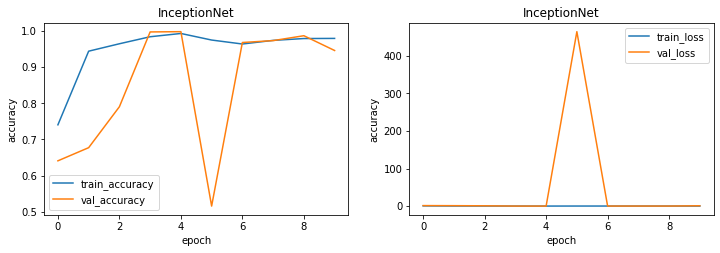

In [ ]:
results(model, history, X_testScaled, Y_testOE,"InceptionNet")

###MobileNetV1

305/305 [==============================] - 3s 8ms/step - loss: 9.2583e-05 - accuracy: 0.9999
Test accuracy: 0.9998973608016968
Test loss: 9.258322097593918e-05


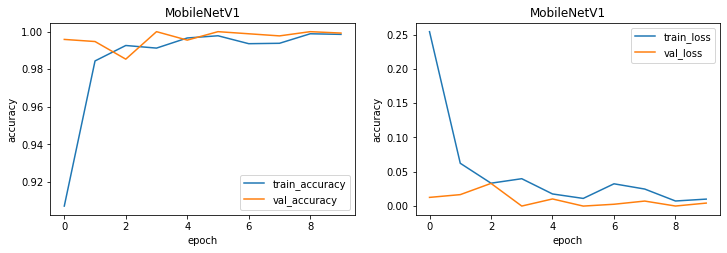

In [ ]:
results(modelMobile,historyMobile, X_testScaled, Y_testOE,"MobileNetV1" )

###ResNet50

305/305 [==============================] - 8s 24ms/step - loss: 4.0240 - accuracy: 0.9578
Test accuracy: 0.9578115344047546
Test loss: 4.024015426635742


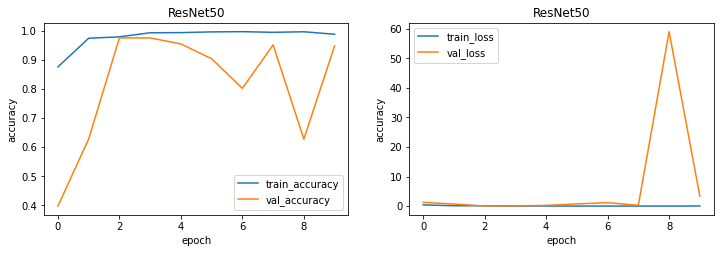

In [ ]:
results(modelRes, historyRes, X_testScaled, Y_testOE,"ResNet50")

###VGG16

305/305 [==============================] - 9s 26ms/step - loss: 0.6931 - accuracy: 0.4987
Test accuracy: 0.49866557121276855
Test loss: 0.6931494474411011


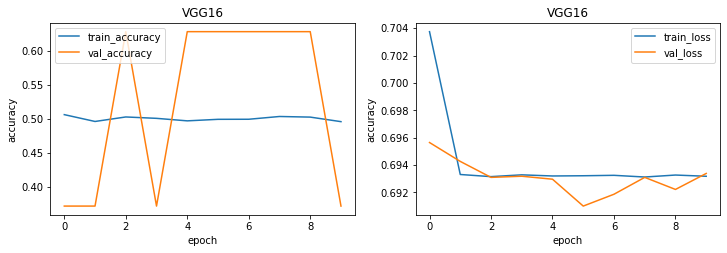

In [ ]:
results(modelVgg, historyVgg, X_testScaled, Y_testOE,"VGG16")

###AlexNet

305/305 [==============================] - 2s 6ms/step - loss: 1.5949 - accuracy: 0.7778
Test accuracy: 0.7777663469314575
Test loss: 1.5949255228042603


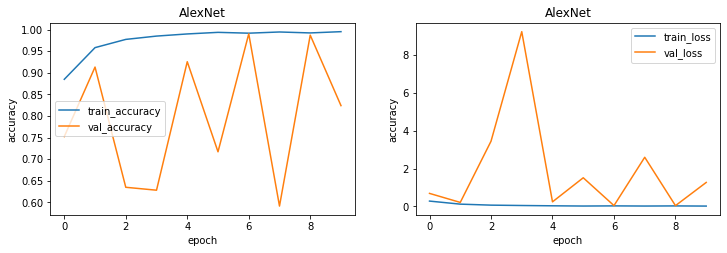

In [ ]:
results(modelAlexnet, historyAlexNet,X_testScaled, Y_testOE,"AlexNet")

##Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
def plot_confusion_matrix(y, y_pred, title):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (10, 10))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix" + title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

###InceptionNet

153/153 [==============================] - 3s 21ms/step


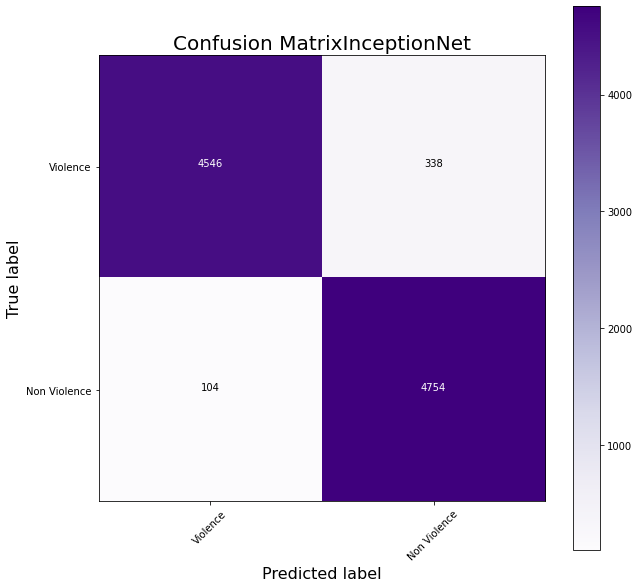

In [ ]:
yPredInception = model.predict(X_testScaled, batch_size = 64)
plot_confusion_matrix(Y_testOE, yPredInception, "InceptionNet")

###MobileNetV1

153/153 [==============================] - 3s 13ms/step


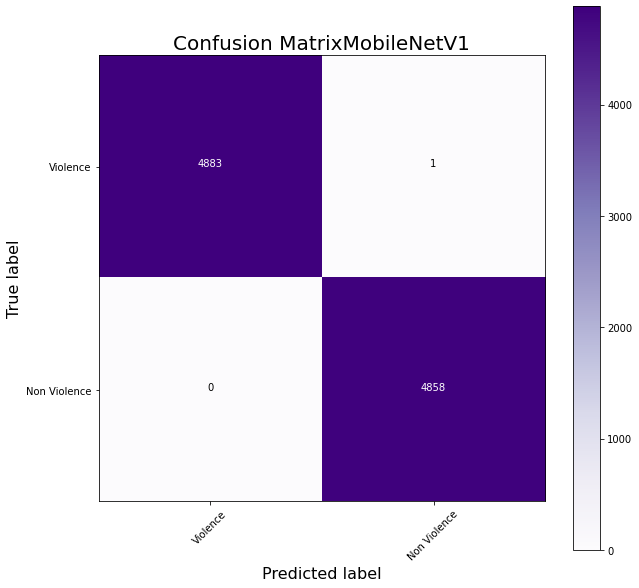

In [ ]:
yPredMobile = modelMobile.predict(X_testScaled, batch_size = 64)
plot_confusion_matrix(Y_testOE, yPredMobile, "MobileNetV1")

###ResNet50

153/153 [==============================] - 6s 31ms/step


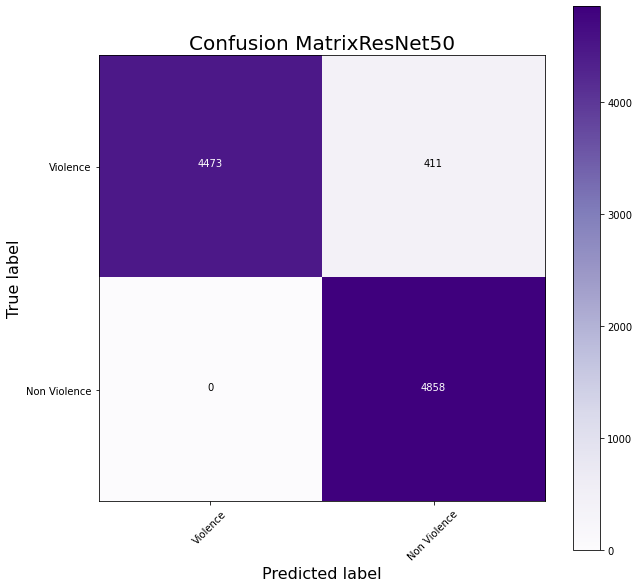

In [ ]:
yPredRes = modelRes.predict(X_testScaled, batch_size = 64)
plot_confusion_matrix(Y_testOE, yPredRes, "ResNet50")

###VGG16

153/153 [==============================] - 6s 40ms/step


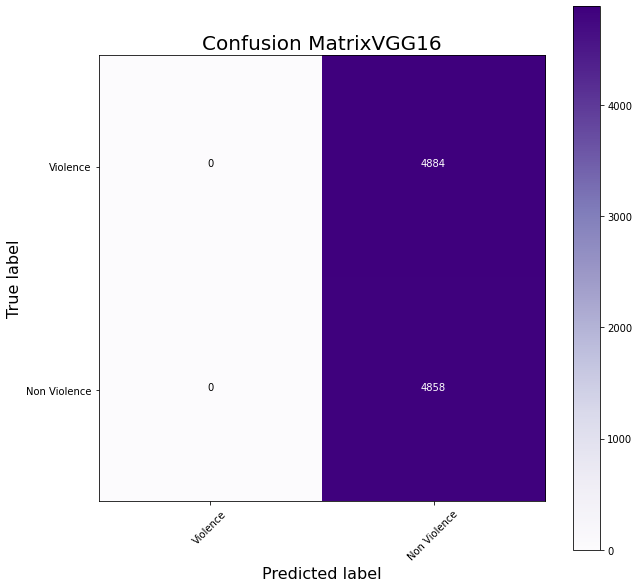

In [ ]:
yPredVgg = modelVgg.predict(X_testScaled, batch_size = 64)
plot_confusion_matrix(Y_testOE, yPredVgg, "VGG16")

###AlexNet

153/153 [==============================] - 1s 7ms/step


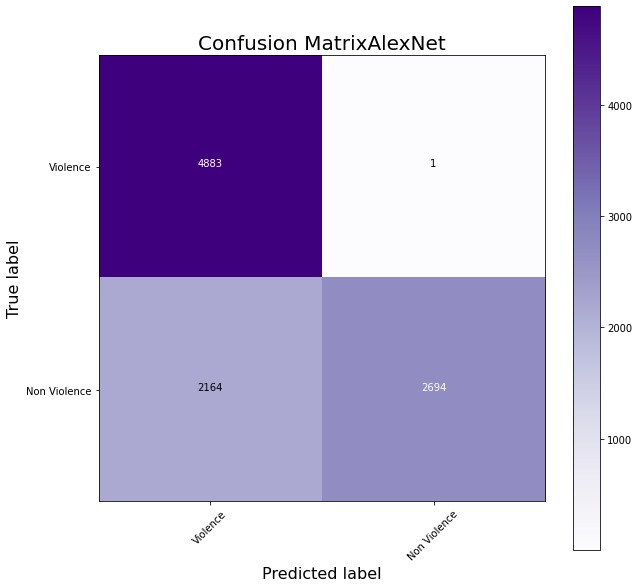

In [ ]:
yPredAlex = modelAlexnet.predict(X_testScaled, batch_size = 64)
plot_confusion_matrix(Y_testOE, yPredAlex, "AlexNet")